### Environment Prep

In [1]:
from pathlib import Path
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

iskaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")   
# os.environ contains info about the envir that this file runs in 
# use list(os.environ.keys()) to see all keys 

if iskaggle:
    %pip install -Uqq fastai    # -qq means very quiet
else:
    import zipfile, kaggle
    path = Path('us-patent-phrase-to-phrase-matching')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

us-patent-phrase-to-phrase-matching.zip: Skipping, found more recently modified local copy (use --force to force download)


### Import & EDA

In [2]:
from fastai.imports import *    # one-liner import for np, pd, plt, etc.

In [3]:
if iskaggle: path = Path('../input/us-patent-phrase-to-phrase-matching')
path.ls()

(#3) [Path('us-patent-phrase-to-phrase-matching/sample_submission.csv'),Path('us-patent-phrase-to-phrase-matching/test.csv'),Path('us-patent-phrase-to-phrase-matching/train.csv')]

In [4]:
df = pd.read_csv(path/"train.csv")
# df.memory_usage() to check memory used

In [5]:
len(df)

36473

In [6]:
df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [7]:
eval_df = pd.read_csv(path/"test.csv")
len(eval_df)

36

In [8]:
df.target.value_counts()

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

We can see that the targets are nearly unique.

In [9]:
df.anchor.value_counts()

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

In [10]:
df.context.value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

In [11]:
df['section'] = df.context.str[0]
df.section.value_counts()

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: section, dtype: int64

<AxesSubplot:>

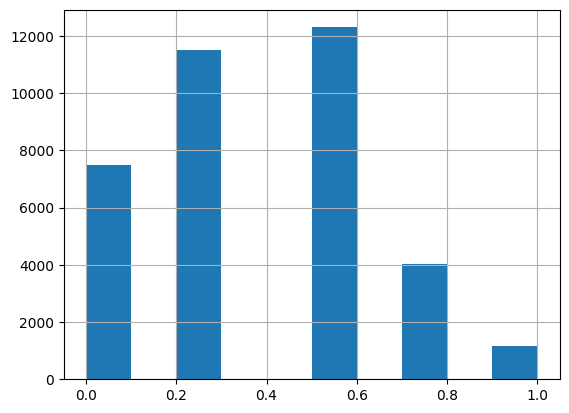

In [12]:
df.score.hist()

In [13]:
df[df.score==1]

,id,anchor,target,context,score,section
28,473137168ebf7484,abatement,abating,F24,1.0,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,B
...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,B


We can see that those items with score 1 tend to have nearly identical anchors and targets. Context seems not so important.

### Feature Eng. & Tokenizing

In [14]:
from torch.utils.data import DataLoader
import warnings, transformers, logging, torch
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [15]:
if iskaggle:
    %pip install -q datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [16]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [17]:
model_nm = 'microsoft/deberta-v3-small'

In [18]:
tokz = AutoTokenizer.from_pretrained(model_nm)

In [19]:
sep = tokz.sep_token
sep

'[SEP]'

In [20]:
tokz.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

In [21]:
tokz.all_special_ids

[1, 2, 3, 0, 128000]

Start by combining all text features (context, anchor, target).

In [22]:
df['inputs'] = df.context + sep + df.anchor + sep + df.target

In [23]:
# convert df to huggingface dset for better performance
ds = Dataset.from_pandas(df).rename_column("score", "label")
eval_ds = Dataset.from_pandas(eval_df)

Define a tokenizing function because Dataset.map() needs it.

In [24]:
def tok_func(x): return tokz(x["inputs"])

In [25]:
tok_func(ds[0])

{'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [26]:
inps = "anchor", "target", "context"

# do below ops in batch:
# tokenize according to tok_func & remove specified columns
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+("inputs", "id", "section"))

  0%|          | 0/37 [00:00<?, ?ba/s]

In [27]:
tok_ds[0]

{'label': 0.5,
 'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### Creating a validation set

Hmm. So when JH sees someone in the discussion leaks some info from the private test set, he just uses it to his advantage (ofc). But what about the principle that you should never see any info from the test set? Anyway, welcome to Kaggle, people.


<span style="text-decoration: underline">Claim: the private test set has totally different anchors than the training data has.</span>

In [28]:
anchors = df.anchor.unique()
np.random.seed(42)
np.random.shuffle(anchors)
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

In [29]:
val_prop = 0.25
val_sz = int(len(anchors) * val_prop)
val_anchors = anchors[:val_sz]

In [30]:
is_val = np.isin(df.anchor, val_anchors)
idxs = np.arange(len(df))
val_idxs = idxs[is_val]
trn_idxs = idxs[~is_val]    # ~ is negation of a binary numpy array
len(val_idxs), len(trn_idxs)

(9116, 27357)

In [31]:
dds = DatasetDict({"train": tok_ds.select(trn_idxs),
                   "test": tok_ds.select(val_idxs)})
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27357
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9116
    })
})

### Initial Model

Create a dictionary for storing the metric because of the inner workings of huggingface Transformers

In [32]:
def corr(eval_pred): return {"pearson": np.corrcoef(*eval_pred)[0][1]}

In [33]:
lr, bs = 8e-5, 64      # when evaluating, double the batch size because there's no backprop
wd, epochs = 0.01, 4

In [34]:
def get_trainer(dds):
    args = TrainingArguments("outputs", 
                             learning_rate=lr,
                             warmup_ratio=0.1,
                             lr_scheduler_type="cosine",
                             fp16=True,  # enable 16-bit training instead of 32-bit, more speed less precision
                             evaluation_strategy="epoch",
                             per_device_train_batch_size=bs,
                             per_device_eval_batch_size=bs*2,
                             num_train_epochs=epochs,
                             weight_decay=wd,
                             report_to="none"
                            )
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
    return Trainer(model, args, train_dataset=dds["train"], eval_dataset=dds["test"],
                   tokenizer=tokz, compute_metrics=corr)

In [ ]:
trainer = get_trainer(dds)

In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.028856,0.787196
2,0.042900,0.024021,0.811435
3,0.019300,0.024761,0.812604
4,0.012500,0.024673,0.815115


TrainOutput(global_step=1712, training_loss=0.02311779865037615, metrics={'train_runtime': 425.5412, 'train_samples_per_second': 257.15, 'train_steps_per_second': 4.023, 'total_flos': 438780707500980.0, 'train_loss': 0.02311779865037615, 'epoch': 4.0})

In [43]:
trainer.save_model("./us-patent-first")

# loading:
# model = AutoModelForSequenceClassification.from_pretrained("./us-patent-first", num_labels=1)

### Improving the model

**Important:**:
before improving, make sure to re-train the first baseline from scratch for multiple times, to estimate a range. If the improvement is not beyond this range, it is not significant. 

In [36]:
def get_dds(df):
    ds = Dataset.from_pandas(df).rename_column("score", "label")
    tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+("inputs", "id", "section"))
    return DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})

def get_model(): return AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

def get_trainer(dds, model=None):
    if model is None: model = get_model()
    args = TrainingArguments("outputs", learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type="cosine",
                             fp16=True, evaluation_strategy="epoch", per_device_train_batch_size=bs, 
                             per_device_eval_batch_size=2*bs, num_train_epochs=epochs, weight_decay=wd, 
                             report_to="none")
    return Trainer(model, args, train_dataset=dds["train"], eval_dataset=dds["test"],
                   tokenizer=tokz, compute_metrics=corr)

**1. Change the separator**

In [35]:
sep = "[s]"
df["inputs"] = df.context + sep + df.anchor + sep + df.target
dds = get_dds(df)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [38]:
get_trainer(dds).train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.027655,0.782517
2,0.042500,0.026846,0.793025
3,0.021300,0.026712,0.796663
4,0.013300,0.026458,0.798451


TrainOutput(global_step=1712, training_loss=0.02393418647975565, metrics={'train_runtime': 446.7234, 'train_samples_per_second': 244.957, 'train_steps_per_second': 3.832, 'total_flos': 569759660178600.0, 'train_loss': 0.02393418647975565, 'epoch': 4.0})

**2. Lower-case all things**

In [37]:
df["inputs"] = df.inputs.str.lower()
dds = get_dds(df)
get_trainer(dds).train()

  0%|          | 0/37 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.028077,0.778428
2,0.046900,0.026456,0.795573
3,0.020800,0.026987,0.798150
4,0.012900,0.026250,0.801042


TrainOutput(global_step=1712, training_loss=0.02489409268459427, metrics={'train_runtime': 468.467, 'train_samples_per_second': 233.587, 'train_steps_per_second': 3.654, 'total_flos': 569759660178600.0, 'train_loss': 0.02489409268459427, 'epoch': 4.0})